# Sentinel 2 CH4 Multi Band Single Pass Mapper

## Overview
Sentinel 5’s spatial resolution is very coarse, so to help users locate emission sources on a landfill, Sentinel 2’s MSI instrument with a 20m2 spatial resolution and return frequency of 3-5 days was employed. 

Varon et al. (2021) demonstrated that methane columns from point sources can be measured by exploiting the SWIR-1 and SWIR-2 bands of Sentinel-2. Their recommended approach utilizes a multi-band-multi-pass (MBMP) retrieval method. However, a multi band single pass (MBSP) method was employed, to simplify the tool for users. A Jupyter workbook containing the MBMP method has been included in this project’s repository for those interested.
The multi-band-single-pass equation is as follows: 

<div align="center"><b>MBSP = B11 - cB12</b></div>

Where:
- B12 is the Sentinel-2 SWIR-2 band.
- B11 is the Sentinel-2 SWIR-1 band. 
- c is calculated using the difference in the median of B12 to B11 and then adding the difference to B12.  

The section below imports the packages needed to run the script.

In [1]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
import openeo
import rasterio
import numpy as np
import requests

## Connect to OpenEO

The code below establishes a connection with the Copernicus openEO platform which provides a wide variety of earth observation datasets

- If this does not read as 'Authorised successfully' or 'Authenticated using refresh token', then please ensure that you have completed the setup steps as outlined in section 2.6 of the user guide. 

- If you have followed the steps in section 2.6 correctly and the problem persists, please look at https://dataspace.copernicus.eu/news for any information about service interruptions. 

- If there is no news of service problems you can raise a ticket here: https://helpcenter.dataspace.copernicus.eu/hc/en-gb/requests/new

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## View list of landfills. 

Each landfill has been asigned an id number. This number can be found in the list produced by the following code. To look at a chosen landfill, you will need to input that number at various stages in the code. Run the code below to the the list. The west, south, east and north columns are latitude and longitude cordinates to establish a box around each landfill for analysis.  

In [3]:
landfill_csv = pd.read_csv(r'C:\GIS_Course\Landfill_Atmospheric_Gas_Monitor_Tools\Data\PreZero_Landfill_Bounding.csv')
landfill_csv

,id,Landfill,west,south,east,north
0,0,ALBACETE,-1.821766,38.959673,-1.731934,39.029490
1,1,ALBOX: MANCOMUNIDAD ALMANZORA LEVANTE,-2.218884,37.354949,-2.129053,37.426322
2,2,ALCALA DEL RIO (LA VEGA-SEVILLA),-6.044366,37.563595,-5.954534,37.634768
3,3,ALCAZAR DE SAN JUAN (COMPLEJO): COMSERMANCHA,-3.270015,39.398232,-3.180184,39.467615
4,4,ALMERIA: CMA,-2.331662,36.842943,-2.241830,36.914799
5,5,CAN MATA (ELS HOSTALETS DE PIEROLA): DC,1.761472,41.497221,1.851303,41.564469
6,6,CANADA HERMOSA: MURCIA,-1.297723,37.979307,-1.284659,37.989031
7,7,DAIMIEL,-3.629513,39.029644,-3.539682,39.099392
8,8,ECOPARQUE DE TOLEDO: GESMAT,-4.208720,39.826702,-4.118888,39.895657
9,9,ECOPARQUE GRAN CANARIA NORTE (SALTO DEL NEGRO),-15.468487,28.019118,15.378655,28.098392


# Available dates for the analysis. 

Unlike Sentinel 5P, Sentinel 2 only provides data aproximately once every 3 days. Because of this, not every date you can enter into this tool is valid. The code below will tell you what dates are available to use for the landfill of your choice. 

The two parameters you need to modify before running the code are: 
- landfill_id = 23 (change this to your chosen landfill) 
- temporal_extent = ["2023-01-31", "2023-03-12"] (change this to your chosen date range using "YYYY-MM-DD" format)

Once you have done this run the code and the available dates should appear below in a matter of a few seconds. 

In [4]:
def get_spatial_extent(landfill_id):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]
    return {
        "west": landfill['west'],
        "south": landfill['south'],
        "east": landfill['east'],
        "north": landfill['north']
    }

def fetch_available_dates(landfill_id, temporal_extent):
    spatial_extent = get_spatial_extent(landfill_id)
    catalog_url = f"https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json?box={spatial_extent['west']}%2C{spatial_extent['south']}%2C{spatial_extent['east']}%2C{spatial_extent['north']}&sortParam=startDate&sortOrder=ascending&page=1&maxRecords=1000&status=ONLINE&dataset=ESA-DATASET&productType=L2A&startDate={temporal_extent[0]}T00%3A00%3A00Z&completionDate={temporal_extent[1]}T00%3A00%3A00Z&cloudCover=%5B0%2C{cloud_cover}%5D"
    response = requests.get(catalog_url)
    response.raise_for_status()
    catalog = response.json()
    dates = [date.split('T')[0] for date in map(lambda x: x['properties']['startDate'], catalog['features'])]
    return dates

# Please enter your perameters here.
landfill_id = 23  # Specify the landfill ID.
temporal_extent = ["2023-01-01", "2023-12-30"]  # Specify the the date range you want to check for available data.
cloud_cover = 15

available_dates = fetch_available_dates(landfill_id, temporal_extent)
print("Available dates:", available_dates)

Available dates: ['2023-01-06', '2023-01-21', '2023-01-23', '2023-01-28', '2023-01-31', '2023-02-02', '2023-02-05', '2023-02-17', '2023-02-22', '2023-02-25', '2023-03-02', '2023-03-04', '2023-03-12', '2023-03-19', '2023-03-22', '2023-03-27', '2023-03-29', '2023-04-06', '2023-04-08', '2023-04-13', '2023-04-18', '2023-04-23', '2023-04-26', '2023-05-01', '2023-05-11', '2023-05-18', '2023-06-15', '2023-06-22', '2023-06-25', '2023-06-27', '2023-06-30', '2023-07-02', '2023-07-07', '2023-07-10', '2023-07-15', '2023-07-17', '2023-07-20', '2023-07-25', '2023-07-27', '2023-07-30', '2023-08-01', '2023-08-04', '2023-08-06', '2023-08-11', '2023-08-14', '2023-08-16', '2023-08-19', '2023-08-21', '2023-08-24', '2023-09-08', '2023-09-10', '2023-09-13', '2023-09-20', '2023-09-23', '2023-09-25', '2023-09-28', '2023-09-30', '2023-10-05', '2023-10-10', '2023-11-19', '2023-11-22', '2023-11-24', '2023-12-02', '2023-12-14', '2023-12-17', '2023-12-19', '2023-12-22', '2023-12-24', '2023-12-27']


## Choosing the Active Emission Date

As mentioned in the overview, an active emission date must be chosen from one of the available datasets. 

Like before, the two parameters you need to modify before running the code are:

- landfill_id = 23 (change this to your chosen landfill)
- temporal_extent = ["2023-02-25", "2023-02-25"] (change this to your chosen date range using "YYYY-MM-DD" format.) 

Please note that the temporal extent dates <u>MUST BE IDENTICAL</u> because we are only choosing a single date.

If you recieve an error message of 'NoDataAvailable' then please check the list of available data above and try again.


In [5]:
def active_emission(landfill_id, temporal_extent):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]

    active_emission = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent={
            "west": landfill['west'],
            "south": landfill['south'],
            "east": landfill['east'],
            "north": landfill['north']
        },
        bands=["B11", "B12"],
    )
    active_emission.download("Sentinel-2_active_emissionMBSP.GTiff")

# Enter parameters for the active emission day
landfill_id = 23  # Specify the landfill ID
temporal_extent = ["2023-02-25", "2023-02-25"]

active_emission(landfill_id, temporal_extent)

## Choosing a Background Satelite Image

This section helps with locating the source of the emission at the landfill by displaying a true colour satelite image of the landfill that the data will be superimposed over. I recommend choosing the same date as your active emission. 

Once again, the two parameters you need to modify before running the code are:

- landfill_id = 23 (change this to your chosen landfill)
- temporal_extent = ["2023-02-25", "2023-02-25"] (change this to your chosen date range using "YYYY-MM-DD" format.)

The temporal extent dates <u>MUST BE IDENTICAL</u>

If you recieve an error message of 'NoDataAvailable' then please check the list of available data above and try again.

In [6]:
def truecolour_image(landfill_id, temporal_extent):
    landfill = landfill_csv[landfill_csv['id'] == landfill_id].iloc[0]

    truecolour_image_collection = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=temporal_extent,
        spatial_extent={
            "west": landfill['west'],
            "south": landfill['south'],
            "east": landfill['east'],
            "north": landfill['north']
        },
        bands=["B02", "B03", "B04"],
    )
    truecolour_image_collection.download("Sentinel-2_truecolourMBSP.GTiff")

# Enter parameters for the no emission day
landfill_id = 23  # Specify the landfill ID
temporal_extent = ["2023-02-25", "2023-02-25"]

truecolour_image(landfill_id, temporal_extent)

## Running the Analysis
Here, no modification by you is needed. The code below runs the analysis.  Provided all the variables above have been run correctly, this next section should take moments to complete. 

In [7]:
# Define file path
Active_Multiband = "Sentinel-2_active_emissionMBSP.GTiff"

# Define each band from the active dataset
with rasterio.open(Active_Multiband) as Active_img:
    Active_B11 = Active_img.read(1)
    Active_B12 = Active_img.read(2)

# Calculate the median difference for Active_B11 and Active_B12
median_diff_active = np.median(Active_B11) - np.median(Active_B12)

# Adjust Active_B12
Corrected_Active_B12 = Active_B12 + median_diff_active

# Calculate the fractional change
SWIR_diff = Active_B11 - Corrected_Active_B12

## Viewing the data. 

This section of code can be run to produce the map. There is one piece of code that can be altered if needed. 

- brightness_factor = 0.05 (occasionally the true colour satelite image can be too bright or too dark. You can change this number to fix it)

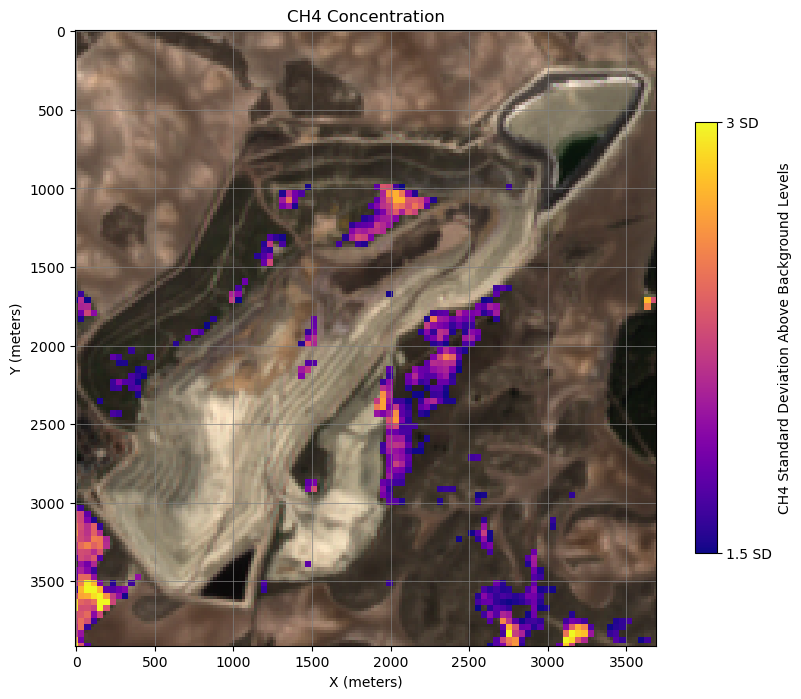

In [8]:
# This section adds the truecolour satellite image.
# Open the and load the truecolour image file and define which band is which.
truecolour_sat = 'Sentinel-2_truecolourMBSP.GTiff'
img = rasterio.open(truecolour_sat)
blue = img.read(1)
green = img.read(2)
red = img.read(3)

# Change this number up or down if the satellite background image is too dark or bright. 
brightness_factor = 0.05 
blue = np.clip(blue * brightness_factor, 0, 255)
green = np.clip(green * brightness_factor, 0, 255)
red = np.clip(red * brightness_factor, 0, 255)

# Stack the blue, green and red bands to make a colour image. 
rgb = np.dstack((red, green, blue))
rgb = rgb / rgb.max()

# Create a new map
plt.figure(figsize=(10, 8))

# Display the RGB image on that map.
plt.imshow(rgb)

# This section adds the methane column data.
# Calculate mean and standard deviation of SWIR_diff.
mean = np.nanmean(SWIR_diff)
std = np.nanstd(SWIR_diff)

# Create a mask to only show values 1.5 SD above the mean.
mask = SWIR_diff < (mean + 1.5 * std)

# Apply the mask
masked_SWIR_diff = np.ma.masked_array(SWIR_diff, mask=mask)

# Set the minimum and maximum displayed data values to be between 1.5 and 3 standard deviations above the mean.
mean = np.nanmean(SWIR_diff)
std = np.nanstd(SWIR_diff)
vmin = mean + 1.5 * std
vmax = mean + 3 * std

# Display the masked_SWIR_diff data on top of the RGB image.
plt.imshow(masked_SWIR_diff, cmap='plasma', alpha=1, vmin=vmin, vmax=vmax)

# This next section adds features to the map to aid in interpretation.
# Add a colorbar and labels
cbar = plt.colorbar(label='CH4 Standard Deviation Above Background Levels', shrink=0.7)
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(['1.5 SD', '3 SD'])
plt.title('CH4 Concentration')

# Dataset resolution in metres.
resolution = 20  
	
# Get the dimensions of the image.
height, width, _ = rgb.shape

# Create axis showing scale in metres with grid lines every 500m.
x = np.arange(0, width * resolution, 500)
y = np.arange(0, height * resolution, 500)
plt.xticks(x / resolution, x)
plt.yticks(y / resolution, y)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.grid(color='gray', linestyle='-', linewidth=0.5)

# Downloading image for use in report
# Please enter the emission date where it says '[emission date here]' if you want to download more than one map.
plt.savefig(f'S2MBSP[emission_date_here].jpg', format='jpg', bbox_inches='tight')

# Show the map
plt.show()